In [1]:
pip install dataretrieval pandas matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from dataretrieval import nwis
from dataretrieval.nwis import get_dv
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
df = nwis.get_record(
    sites="13073000",           # Topaz
    service="dv",
    start="1985-11-01",
    end="2024-10-01",
    parameterCd="00060"
)

df.head()

,site_no,00060_Mean,00060_Mean_cd
datetime,,,
1985-11-01 00:00:00+00:00,13073000,197.0,A
1985-11-02 00:00:00+00:00,13073000,197.0,A
1985-11-03 00:00:00+00:00,13073000,195.0,A
1985-11-04 00:00:00+00:00,13073000,195.0,A
1985-11-05 00:00:00+00:00,13073000,199.0,A


In [4]:
# create a folder
os.makedirs("Discharge_Data", exist_ok=True)

# list all stations
stations = {
    "Topaz": ("13073000", "1985-11-01"),
    "Pocatello": ("13075500", "1985-11-01"),
    "Tyhee": ("13075910", "1985-11-01"),
    "Marsh_McCammon": ("13075000", "1985-11-01"),
    "Inkom": ("13074400", "2024-01-01"),         # new station
    "Toponce": ("13071010", "2024-01-01"),       # new station
    "Pebble": ("13072400", "2024-01-01"),        # new station
    "Marsh_Hawkins": ("13074810", "2024-01-01")  # new station
}

end_date = "2024-10-31"

In [5]:
# retrieve data for each station and save to CSV"
for name, (code, start_date) in stations.items():
    print(f"▶️ Streamflow data is being fetched {name} ({code})")
    try:
        df, meta = get_dv(
            sites=code,
            parameterCd="00060",
            start=start_date,
            end=end_date
        )

        if df.empty:
            print(f"⚠️ {name}: Returned data is empty.\n")
            continue

        df.index = pd.to_datetime(df.index)
        df = df.rename(columns={"00060_Mean": "Discharge(cfs)"})
        df["Site"] = name

        output_path = f"Discharge_Data/{name}_Discharge.csv"
        df.to_csv(output_path)
        print(f"✓ Saved: {output_path}\n")

    except Exception as e:
        print(f"❌ ERROR ({name} - {code}): {e}\n")

▶️ Streamflow data is being fetched Topaz (13073000)
✓ Saved: Discharge_Data/Topaz_Discharge.csv

▶️ Streamflow data is being fetched Pocatello (13075500)
✓ Saved: Discharge_Data/Pocatello_Discharge.csv

▶️ Streamflow data is being fetched Tyhee (13075910)
✓ Saved: Discharge_Data/Tyhee_Discharge.csv

▶️ Streamflow data is being fetched Marsh_McCammon (13075000)
✓ Saved: Discharge_Data/Marsh_McCammon_Discharge.csv

▶️ Streamflow data is being fetched Inkom (13074400)
✓ Saved: Discharge_Data/Inkom_Discharge.csv

▶️ Streamflow data is being fetched Toponce (13071010)
✓ Saved: Discharge_Data/Toponce_Discharge.csv

▶️ Streamflow data is being fetched Pebble (13072400)
✓ Saved: Discharge_Data/Pebble_Discharge.csv

▶️ Streamflow data is being fetched Marsh_Hawkins (13074810)
✓ Saved: Discharge_Data/Marsh_Hawkins_Discharge.csv



In [6]:
pd.read_csv("Discharge_Data/Pebble_Discharge.csv").head()

,datetime,site_no,Discharge(cfs),00060_Mean_cd,Site
0,2024-07-18 00:00:00+00:00,13072400,134.0,P,Pebble
1,2024-07-19 00:00:00+00:00,13072400,127.0,P,Pebble
2,2024-07-20 00:00:00+00:00,13072400,124.0,P,Pebble
3,2024-07-21 00:00:00+00:00,13072400,122.0,P,Pebble
4,2024-07-22 00:00:00+00:00,13072400,118.0,P,Pebble


In [7]:
# load data from a CSV file and convert the datetime column to datetime format
df = pd.read_csv("Discharge_Data/Topaz_Discharge.csv", parse_dates=["datetime"])
df = df.rename(columns={"Discharge(cfs)": "Q(cfs)"})
df = df.set_index("datetime")

# irrigation year
def get_irrigation_year(date):
    return date.year + 1 if date.month >= 11 else date.year

df["Irrigation_Year"] = df.index.map(get_irrigation_year)

# for each day, the flow volume in cubic feet (ft³) is calculated as: cfs × 86,400 seconds per day
df["Q(ft3/day)"] = df["Q(cfs)"] * 86400

# compute total flow volume (in ft³ per year) for each irrigation year
annual_Q_ft3 = df.groupby("Irrigation_Year")["Q(ft3/day)"].sum()

# show the results
print(annual_Q_ft3.head())

Irrigation_Year
1986    1.070842e+10
1987    6.287760e+09
1988    4.729277e+09
1989    5.313082e+09
1990    4.493146e+09
Name: Q(ft3/day), dtype: float64


In [8]:
# path the folder
folder_path = "Discharge_Data"

# retrieve all discharge-related CSV files from the folder
file_list = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

summary_df = pd.DataFrame()

# irrigatıon year function
def get_irrigation_year(date):
    return date.year + 1 if date.month >= 11 else date.year

# loop through and process all files
for file in file_list:
    station_name = file.replace("_Discharge.csv", "")
    df = pd.read_csv(os.path.join(folder_path, file), parse_dates=["datetime"])
    df = df.rename(columns={"Discharge(cfs)": "Q(cfs)"})
    df = df.set_index("datetime")

    # add an irrigation year
    df["Irrigation_Year"] = df.index.map(get_irrigation_year)

    # daily volume: Q(cfs) × 86400 = ft³/day
    df["Q(ft3/day)"] = df["Q(cfs)"] * 86400

    # yearly total volume (ft³/year)
    annual = df.groupby("Irrigation_Year")["Q(ft3/day)"].sum()
    annual.name = station_name  # set the column name as the station name

    summary_df = pd.concat([summary_df, annual], axis=1)

# total discharge volume (ft³/year)
summary_df["Total_Discharge_(ft^3/year)"] = summary_df.sum(axis=1)
summary_df = summary_df.sort_index()

# 7. save the files as a CSV
output_path = "Irrigation_Year_Discharge_Volume_Summary.csv"
summary_df.to_csv(output_path)

print(f"✓ Process completed! Output file: {output_path}")

✓ Process completed! Output file: Irrigation_Year_Discharge_Volume_Summary.csv


In [9]:
# Area values (square miles) – entered by the user
area_mi2 = {
    "Inkom": 1065,
    "Marsh_Hawkins": 179,
    "Marsh_McCammon": 353,
    "Pebble": 261,
    "Pocatello": 1256,
    "Topaz": 576,
    "Toponce": 92,
    "Tyhee": 1305
}

# 1 mi² = 27,878,400 ft²
SQMI_TO_FT2 = 27878400

# create a DataFrame
area_df = pd.DataFrame({
    "Station": list(area_mi2.keys()),
    "Area_sqmi": list(area_mi2.values())
})

# calculate as the square feet
area_df["Area_ft2"] = area_df["Area_sqmi"] * SQMI_TO_FT2

# show the results
print(area_df)

# save as a CSV file
area_df.to_csv("Station_Area_Info.csv", index=False)

          Station  Area_sqmi     Area_ft2
0           Inkom       1065  29690496000
1   Marsh_Hawkins        179   4990233600
2  Marsh_McCammon        353   9841075200
3          Pebble        261   7276262400
4       Pocatello       1256  35015270400
5           Topaz        576  16057958400
6         Toponce         92   2564812800
7           Tyhee       1305  36381312000


In [10]:
# read the file
discharge_df = pd.read_csv("Irrigation_Year_Discharge_Volume_Summary.csv", index_col=0)

FT_TO_MM = 304.8        # 1 foot = 304.8 mm

# create an empty runoff depth DataFrame
runoff_depth_df = pd.DataFrame(index=discharge_df.index)

# calculate runoff depth for each station (mm/year)
for station, area_sqmi in area_mi2.items():
    if station in discharge_df.columns:
        area_ft2 = area_sqmi * SQMI_TO_FT2
        runoff_depth_df[station + "_Runoff_mm"] = (discharge_df[station] / area_ft2) * FT_TO_MM
    else:
        print(f"⚠️ Warning: Discharge file for {station} not found!")
# annual total runoff depth (mm/year)
runoff_depth_df["Total_Runoff_mm"] = runoff_depth_df.sum(axis=1)

# save the results into a new CSV file
runoff_depth_df.to_csv("Irrigation_Year_Runoff_Depth_mm.csv")

print("✓ Runoff depth has been calculated and saved to the 'Irrigation_Year_Runoff_Depth_mm.csv' file.")

✓ Runoff depth has been calculated and saved to the 'Irrigation_Year_Runoff_Depth_mm.csv' file.


In [11]:
# read the runoff CSV file
runoff_df = pd.read_csv("Irrigation_Year_Runoff_Depth_mm.csv")
runoff_df = runoff_df.rename(columns={runoff_df.columns[0]: "Year"})
runoff_df = runoff_df.set_index("Year")

# read the precipitation values' file
precip_df = pd.read_excel("Precipitation_Yearly_Data.xlsx")
precip_df = precip_df.set_index("Year")

runoff_col = "Total_Runoff_mm"
precip_col = "Precipitation_Values_(mm/year)"

# create a combined DataFrame
combined_df = pd.DataFrame()
combined_df["Total_Runoff_mm"] = runoff_df[runoff_col]
combined_df["Precipitation_mm"] = precip_df[precip_col]

# calculate Runoff Efficiency
combined_df["Runoff_Efficiency_%"] = (combined_df["Total_Runoff_mm"] / combined_df["Precipitation_mm"])

# save the results into a new CSV file
combined_df.to_csv("Runoff_Efficiency_Results.csv")

print("✓ Runoff efficiency was successfully calculated and saved to the 'Runoff_Efficiency_Results.csv' file.")

✓ Runoff efficiency was successfully calculated and saved to the 'Runoff_Efficiency_Results.csv' file.


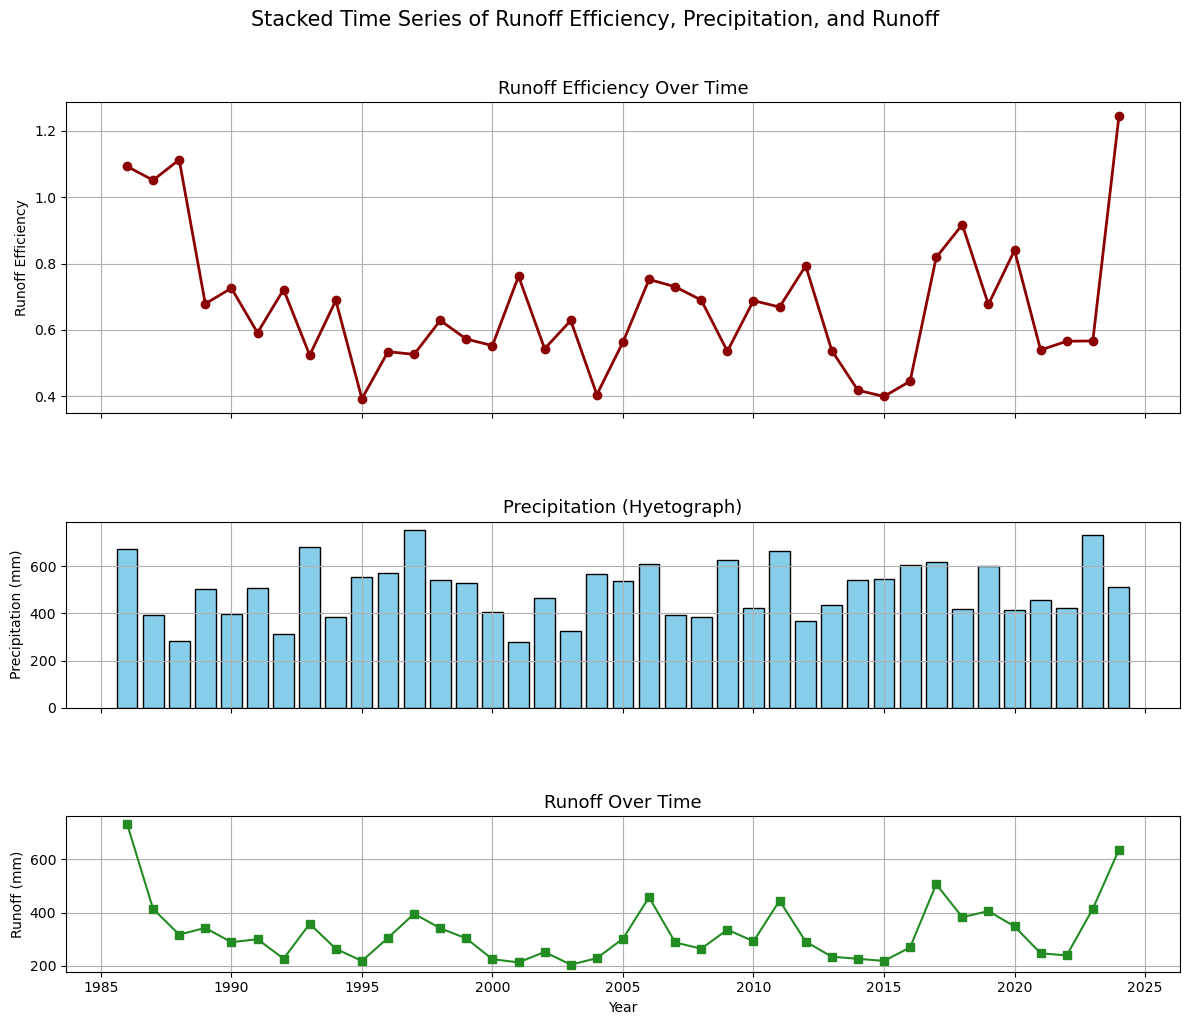

In [12]:
# Read the file and rename columns
df = pd.read_csv("Runoff_Efficiency_Results.csv")
df = df.rename(columns={
    "Total_Runoff_mm": "Runoff (mm)",
    "Precipitation_mm": "Precipitation (mm)",
    "Runoff_Efficiency_%": "Runoff Efficiency"
})
df = df.sort_values("Year")

years = df["Year"]

# Create the figure with 3 stacked subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10), sharex=True,
                         gridspec_kw={'height_ratios': [2, 1.2, 1]})

# Panel 1: Runoff Efficiency (highlighted)
axes[0].plot(years, df["Runoff Efficiency"], color="darkred", marker='o', linewidth=2)
axes[0].set_ylabel("Runoff Efficiency")
axes[0].set_title("Runoff Efficiency Over Time", fontsize=13)
axes[0].grid(True)

# Panel 2: Precipitation (hyetograph - bar plot)
axes[1].bar(years, df["Precipitation (mm)"], color="skyblue", edgecolor="black")
axes[1].set_ylabel("Precipitation (mm)")
axes[1].set_title("Precipitation (Hyetograph)", fontsize=13)
axes[1].grid(True)

# Panel 3: Runoff (line plot)
axes[2].plot(years, df["Runoff (mm)"], color="forestgreen", marker='s')
axes[2].set_ylabel("Runoff (mm)")
axes[2].set_xlabel("Year")
axes[2].set_title("Runoff Over Time", fontsize=13)
axes[2].grid(True)

# Overall title and layout adjustments
fig.suptitle("Stacked Time Series of Runoff Efficiency, Precipitation, and Runoff", fontsize=15, y=1.02)
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

# Save and display
plt.savefig("Stacked_Runoff_Analysis.png", dpi=300, bbox_inches='tight')
plt.show()

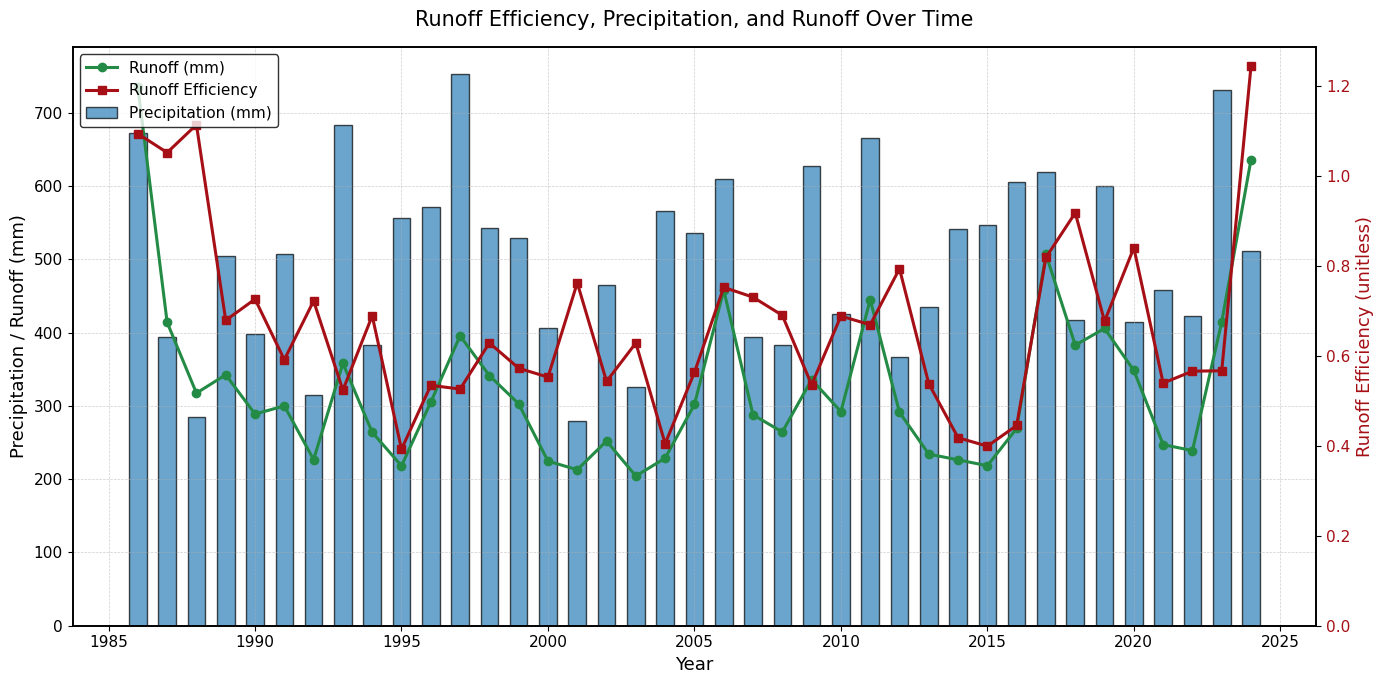

In [13]:
# Style settings
plt.rcParams.update({
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "font.size": 12,
    "axes.titlesize": 15,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})

# Load the data and rename columns
df = pd.read_csv("Runoff_Efficiency_Results.csv")
df = df.rename(columns={
    "Total_Runoff_mm": "Runoff (mm)",
    "Precipitation_mm": "Precipitation (mm)",
    "Runoff_Efficiency_%": "Runoff Efficiency"
})
df = df.sort_values("Year")
years = df["Year"]

# Create the figure
fig, ax1 = plt.subplots(figsize=(14, 7), facecolor='white')

# Precipitation - bar plot (hyetograph)
bar = ax1.bar(
    years, df["Precipitation (mm)"],
    width=0.6, color='#2c7fb8', edgecolor='black',
    label='Precipitation (mm)', alpha=0.7
)

# Runoff - line plot
line1 = ax1.plot(
    years, df["Runoff (mm)"],
    color='#238b45', marker='o', markersize=6,
    linewidth=2.2, label='Runoff (mm)'
)

# Left Y-axis settings
ax1.set_xlabel("Year")
ax1.set_ylabel("Precipitation / Runoff (mm)")
ax1.tick_params(axis='y')
ax1.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.6)
for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)

# Right Y-axis - Runoff Efficiency
ax2 = ax1.twinx()
line2 = ax2.plot(
    years, df["Runoff Efficiency"],
    color='#a50f15', marker='s', markersize=6,
    linewidth=2.2, label='Runoff Efficiency'
)
ax2.set_ylabel("Runoff Efficiency (unitless)", color='#a50f15')
ax2.tick_params(axis='y', labelcolor='#a50f15')
ax2.set_ylim(bottom=0)

# Right axis frame settings
for spine in ax2.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.2)

# Title and legend
plt.title("Runoff Efficiency, Precipitation, and Runoff Over Time", pad=15)

# Combine all plot elements for the legend
lines = line1 + line2 + [bar]
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='upper left', frameon=True, edgecolor='black')

# Final layout and save
plt.tight_layout()
plt.savefig("Runoff_Analysis_Academic_Style.png", dpi=300)
plt.show()